In [ ]:
!pip -q install complexipy pandas matplotlib

import os
import json
import textwrap
import subprocess
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt

from complexipy import code_complexity, file_complexity

print("✅ Installed complexipy and dependencies")

In [ ]:
snippet = """
def score_orders(orders):
    total = 0
    for o in orders:
        if o.get("valid"):
            if o.get("priority"):
                if o.get("amount", 0) > 100:
                    total += 3
                else:
                    total += 2
            else:
                if o.get("amount", 0) > 100:
                    total += 2
                else:
                    total += 1
        else:
            total -= 1
    return total
"""

res = code_complexity(snippet)
print("=== Code string complexity ===")
print("Overall complexity:", res.complexity)
print("Functions:")
for f in res.functions:
    print(f" - {f.name}: {f.complexity} (lines {f.line_start}-{f.line_end})")

In [ ]:
root = Path("toy_project")
src = root / "src"
tests = root / "tests"
src.mkdir(parents=True, exist_ok=True)
tests.mkdir(parents=True, exist_ok=True)

(src / "__init__.py").write_text("")
(tests / "__init__.py").write_text("")

(src / "simple.py").write_text(textwrap.dedent("""
def add(a, b):
    return a + b

def safe_div(a, b):
    if b == 0:
        return None
    return a / b
""").strip() + "\n")

(src / "legacy_adapter.py").write_text(textwrap.dedent("""
def legacy_adapter(x, y):
    if x and y:
        if x > 0:
            if y > 0:
                return x + y
            else:
                return x - y
        else:
            if y > 0:
                return y - x
            else:
                return -(x + y)
    return 0
""").strip() + "\n")

(src / "engine.py").write_text(textwrap.dedent("""
def route_event(event):
    kind = event.get("kind")
    payload = event.get("payload", {})
    if kind == "A":
        if payload.get("x") and payload.get("y"):
            return _handle_a(payload)
        return None
    elif kind == "B":
        if payload.get("flags"):
            return _handle_b(payload)
        else:
            return None
    elif kind == "C":
        for item in payload.get("items", []):
            if item.get("enabled"):
                if item.get("mode") == "fast":
                    _do_fast(item)
                else:
                    _do_safe(item)
        return True
    else:
        return None

def _handle_a(p):
    total = 0
    for v in p.get("vals", []):
        if v > 10:
            total += 2
        else:
            total += 1
    return total

def _handle_b(p):
    score = 0
    for f in p.get("flags", []):
        if f == "x":
            score += 1
        elif f == "y":
            score += 2
        else:
            score -= 1
    return score

def _do_fast(item):
    return item.get("id")

def _do_safe(item):
    if item.get("id") is None:
        return None
    return item.get("id")
""").strip() + "\n")

(tests / "test_engine.py").write_text(textwrap.dedent("""
from src.engine import route_event

def test_route_event_smoke():
    assert route_event({"kind": "A", "payload": {"x": 1, "y": 2, "vals": [1, 20]}}) == 3
""").strip() + "\n")

print(f"✅ Created project at: {root.resolve()}")

In [ ]:
engine_path = src / "engine.py"
file_res = file_complexity(str(engine_path))

print("\n=== File complexity (Python API) ===")
print("Path:", file_res.path)
print("File complexity:", file_res.complexity)
for f in file_res.functions:
    print(f" - {f.name}: {f.complexity} (lines {f.line_start}-{f.line_end})")

MAX_ALLOWED = 8

def run_complexipy_cli(project_dir: Path, max_allowed: int = 8):
    cmd = [
        "complexipy",
        ".",
        "--max-complexity-allowed", str(max_allowed),
        "--output-json",
        "--output-csv",
    ]
    proc = subprocess.run(cmd, cwd=str(project_dir), capture_output=True, text=True)

    preferred_csv = project_dir / "complexipy.csv"
    preferred_json = project_dir / "complexipy.json"

    csv_candidates = []
    json_candidates = []

    if preferred_csv.exists():
        csv_candidates.append(preferred_csv)
    if preferred_json.exists():
        json_candidates.append(preferred_json)

    csv_candidates += list(project_dir.glob("*.csv")) + list(project_dir.glob("**/*.csv"))
    json_candidates += list(project_dir.glob("*.json")) + list(project_dir.glob("**/*.json"))

    def uniq(paths):
        seen = set()
        out = []
        for p in paths:
            p = p.resolve()
            if p not in seen and p.is_file():
                seen.add(p)
                out.append(p)
        return out

    csv_candidates = uniq(csv_candidates)
    json_candidates = uniq(json_candidates)

    def pick_best(paths):
        if not paths:
            return None
        paths = sorted(paths, key=lambda p: p.stat().st_mtime, reverse=True)
        return paths[0]

    return proc.returncode, pick_best(csv_candidates), pick_best(json_candidates)

rc, csv_report, json_report = run_complexipy_cli(root, MAX_ALLOWED)

In [ ]:
df = None

if csv_report and csv_report.exists():
    df = pd.read_csv(csv_report)
elif json_report and json_report.exists():
    data = json.loads(json_report.read_text())
    if isinstance(data, list):
        df = pd.DataFrame(data)
    elif isinstance(data, dict):
        if "files" in data and isinstance(data["files"], list):
            df = pd.DataFrame(data["files"])
        elif "results" in data and isinstance(data["results"], list):
            df = pd.DataFrame(data["results"])
        else:
            df = pd.json_normalize(data)

if df is None:
    raise RuntimeError("No report produced")

def explode_functions_table(df_in):
    if "functions" in df_in.columns:
        tmp = df_in.explode("functions", ignore_index=True)
        if tmp["functions"].notna().any() and isinstance(tmp["functions"].dropna().iloc[0], dict):
            fn = pd.json_normalize(tmp["functions"])
            base = tmp.drop(columns=["functions"])
            return pd.concat([base.reset_index(drop=True), fn.reset_index(drop=True)], axis=1)
        return tmp
    return df_in

fn_df = explode_functions_table(df)

col_map = {}
for c in fn_df.columns:
    lc = c.lower()
    if lc in ("path", "file", "filename", "module"):
        col_map[c] = "path"
    if ("function" in lc and "name" in lc) or lc in ("function", "func", "function_name"):
        col_map[c] = "function"
    if lc == "name" and "function" not in fn_df.columns:
        col_map[c] = "function"
    if "complexity" in lc and "allowed" not in lc and "max" not in lc:
        col_map[c] = "complexity"
    if lc in ("line_start", "linestart", "start_line", "startline"):
        col_map[c] = "line_start"
    if lc in ("line_end", "lineend", "end_line", "endline"):
        col_map[c] = "line_end"

fn_df = fn_df.rename(columns=col_map)

✅ Installed complexipy and dependencies
=== Code string complexity ===
Overall complexity: 18
Functions:
 - score_orders: 18 (lines 2-18)
✅ Created project at: /content/toy_project

=== File complexity (Python API) ===
Path: engine.py
File complexity: 30
 - route_event: 20 (lines 1-22)
 - _handle_a: 4 (lines 24-31)
 - _handle_b: 5 (lines 33-42)
 - _do_fast: 0 (lines 44-45)
 - _do_safe: 1 (lines 47-50)

Running (cwd=toy_project): complexipy . --max-complexity-allowed 8 --output-json --output-csv

=== CLI STDOUT ===
──────────────────────────────── 🐙 complexipy ─────────────────────────────────
Results saved at 
/content/toy_project/complexipy_results_2026_01_14__12-50-07.csv
Results saved at 
/content/toy_project/complexipy_results_2026_01_14__12-50-07.json
./src/engine.py
    _do_fast 0 PASSED
    _do_safe 1 PASSED
    _handle_a 4 PASSED
    _handle_b 5 PASSED
    route_event 20 FAILED

./src/simple.py
    add 0 PASSED
    safe_div 1 PASSED

./tests/test_engine.py
    test_route_event_

,Path,File Name,Function Name,Cognitive Complexity
0,./src/engine.py,engine.py,_do_fast,0
1,./src/simple.py,simple.py,add,0
2,./tests/test_engine.py,test_engine.py,test_route_event_smoke,0
3,./src/engine.py,engine.py,_do_safe,1
4,./src/simple.py,simple.py,safe_div,1
5,./src/engine.py,engine.py,_handle_a,4
6,./src/engine.py,engine.py,_handle_b,5
7,./src/engine.py,engine.py,route_event,20



=== Normalized function-level view (best effort) ===


,path,File Name,function,complexity
0,./src/engine.py,engine.py,_do_fast,0
1,./src/simple.py,simple.py,add,0
2,./tests/test_engine.py,test_engine.py,test_route_event_smoke,0
3,./src/engine.py,engine.py,_do_safe,1
4,./src/simple.py,simple.py,safe_div,1
5,./src/engine.py,engine.py,_handle_a,4
6,./src/engine.py,engine.py,_handle_b,5
7,./src/engine.py,engine.py,route_event,20



=== Top 15 most complex functions ===


,path,File Name,function,complexity
7,./src/engine.py,engine.py,route_event,20
6,./src/engine.py,engine.py,_handle_b,5
5,./src/engine.py,engine.py,_handle_a,4
3,./src/engine.py,engine.py,_do_safe,1
4,./src/simple.py,simple.py,safe_div,1
2,./tests/test_engine.py,test_engine.py,test_route_event_smoke,0
0,./src/engine.py,engine.py,_do_fast,0
1,./src/simple.py,simple.py,add,0



Stats: worst=20.00, mean=3.88, p90=9.50
Quality gate: max complexity <= 8 ? ❌ FAIL


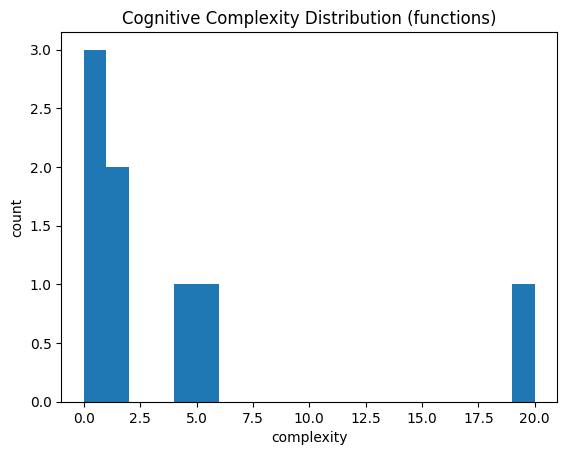


Snippet extraction skipped (missing one of: path, function, complexity, line_start, line_end).

=== Refactoring hints for top offenders ===

- route_event  complexity=20
  • Split into smaller pure functions (one responsibility each).
  • Replace deep nesting with guard clauses / early returns.
  • Extract complex boolean conditions into named predicates.

- _handle_b  complexity=5
  • Looks reasonable; keep an eye on future growth.

- _handle_a  complexity=4
  • Looks reasonable; keep an eye on future growth.

- _do_safe  complexity=1
  • Looks reasonable; keep an eye on future growth.

- safe_div  complexity=1
  • Looks reasonable; keep an eye on future growth.

- test_route_event_smoke  complexity=0
  • Looks reasonable; keep an eye on future growth.

- _do_fast  complexity=0
  • Looks reasonable; keep an eye on future growth.

- add  complexity=0
  • Looks reasonable; keep an eye on future growth.

✅ Tutorial complete.


In [2]:
if "complexity" in fn_df.columns:
    fn_df["complexity"] = pd.to_numeric(fn_df["complexity"], errors="coerce")
    plt.figure()
    fn_df["complexity"].dropna().plot(kind="hist", bins=20)
    plt.title("Cognitive Complexity Distribution (functions)")
    plt.xlabel("complexity")
    plt.ylabel("count")
    plt.show()

def refactor_hints(complexity):
    if complexity >= 20:
        return [
            "Split into smaller pure functions",
            "Replace deep nesting with guard clauses",
            "Extract complex boolean predicates"
        ]
    if complexity >= 12:
        return [
            "Extract inner logic into helpers",
            "Flatten conditionals",
            "Use dispatch tables"
        ]
    if complexity >= 8:
        return [
            "Reduce nesting",
            "Early returns"
        ]
    return ["Acceptable complexity"]

if "complexity" in fn_df.columns and "function" in fn_df.columns:
    for _, r in fn_df.sort_values("complexity", ascending=False).head(8).iterrows():
        cx = float(r["complexity"]) if pd.notna(r["complexity"]) else None
        if cx is None:
            continue
        print(r["function"], cx, refactor_hints(cx))

print("✅ Tutorial complete.")